# 04 - Feature Insights (Gene Analysis)

## Objective
Analyze which genes drive PAM50 subtype classification and assess feature selection stability.

## Contents
1. Extract ElasticNet coefficients per class
2. Identify top positive/negative genes per subtype
3. Analyze selection stability across CV folds
4. Visualize key gene expression patterns
5. Statistical validation (Kruskal-Wallis)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

from scipy import stats as sp_stats

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [32]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
TABLES_DIR = REPORTS_DIR / "tables"

for d in [FIGURES_DIR, TABLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

EXPRESSION_FILE = "HiSeqV2.csv"
PAM50_LABELS_FILE = "brca_pam50.csv.csv"

RANDOM_SEED = 42
CV_FOLDS = 5
VARIANCE_THRESHOLD = 0.01
LOG_TRANSFORM_THRESHOLD = 100
DEFAULT_FEATURE_K = 200
PRIMARY_METRIC = "f1_macro"
TOP_K_GENES = 20
STABILITY_THRESHOLD = 0.5

SAMPLE_ID_CANDIDATES = ["sample", "sample_id", "patient_id", "barcode", "Sample", "SAMPLE_ID"]
PAM50_LABEL_CANDIDATES = ["PAM50", "pam50", "Subtype", "subtype", "label", "Label"]
EXCLUDED_LABELS = ["Unknown", "unknown", "NA", "N/A", "", None]

ELASTICNET_PARAMS = {"C": list(np.logspace(-3, 2, 10)), "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]}
ELASTICNET_DEFAULTS = {"solver": "saga", "penalty": "elasticnet", "class_weight": "balanced",
                        "max_iter": 5000, "random_state": RANDOM_SEED, "n_jobs": -1}

PAM50_COLORS = {
    "LumA": "#3498db", "LumB": "#2ecc71", "Her2": "#e74c3c",
    "Basal": "#9b59b6", "Normal": "#f39c12",
}

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

plt.rcParams.update({
    "figure.dpi": 100, "savefig.dpi": 150, "font.size": 10,
    "axes.labelsize": 11, "axes.titlesize": 12, "legend.fontsize": 9,
    "figure.figsize": (8, 6), "axes.spines.top": False, "axes.spines.right": False,
})

In [33]:
class Log2Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=100.0, force=False):
        self.threshold = threshold
        self.force = force
        self.applied_ = False
    def fit(self, X, y=None):
        self.applied_ = self.force or (np.nanmax(np.asarray(X)) > self.threshold)
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        if self.applied_:
            X = np.log2(np.clip(X, 0, None) + 1)
        return X
    def get_feature_names_out(self, input_features=None):
        return input_features


def normalize_sample_id(sid):
    sid = str(sid).strip()
    return sid[:15] if sid.startswith("TCGA-") and len(sid) >= 15 else sid


def load_data():
    df = pd.read_csv(DATA_DIR / EXPRESSION_FILE, index_col=0)
    if any(str(c).startswith("TCGA-") for c in df.columns[:10]):
        df = df.T
    df.index = [normalize_sample_id(s) for s in df.index]
    df = df.apply(pd.to_numeric, errors="coerce")
    print(f"Expression: {df.shape}")

    ldf = pd.read_csv(DATA_DIR / PAM50_LABELS_FILE)
    sc = next((c for c in SAMPLE_ID_CANDIDATES if c in ldf.columns), ldf.columns[0])
    lc = next((c for c in PAM50_LABEL_CANDIDATES if c in ldf.columns), ldf.columns[1])
    labels = ldf[[sc, lc]].copy()
    labels.columns = ["sample_id", "PAM50"]
    labels["sample_id"] = labels["sample_id"].apply(normalize_sample_id)
    labels = labels.drop_duplicates(subset="sample_id", keep="first")
    labels = labels[~labels["PAM50"].isin(EXCLUDED_LABELS)]

    overlap = set(df.index) & set(labels["sample_id"])
    labels = labels[labels["sample_id"].isin(overlap)]
    X = df.loc[labels["sample_id"].values]
    y = pd.Series(labels["PAM50"].values, name="PAM50")
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    print(f"Labeled: {len(y)}")
    return X, y


def _safe_cv_folds(y, cv_folds):
    mc = pd.Series(y).value_counts().min()
    return max(2, mc) if mc < cv_folds else cv_folds


def create_elasticnet_pipeline(n_features=DEFAULT_FEATURE_K, C=1.0, l1_ratio=0.5):
    return Pipeline([
        ("log_transform", Log2Transformer(threshold=LOG_TRANSFORM_THRESHOLD)),
        ("variance_filter", VarianceThreshold(threshold=VARIANCE_THRESHOLD)),
        ("scaler", StandardScaler()),
        ("feature_selector", SelectKBest(score_func=f_classif, k=n_features)),
        ("classifier", LogisticRegression(C=C, l1_ratio=l1_ratio, **ELASTICNET_DEFAULTS)),
    ])

In [34]:
def extract_coefficients(pipeline, feature_names):
    """Extract coefficients from fitted ElasticNet, tracking features through selection steps."""
    classifier = pipeline.named_steps["classifier"]
    current_features = list(feature_names)
    current_mask = np.ones(len(feature_names), dtype=bool)

    for name, step in pipeline.named_steps.items():
        if name == "classifier":
            break
        if isinstance(step, (VarianceThreshold, SelectKBest)):
            step_mask = step.get_support()
            new_features, new_mask = [], np.zeros(len(feature_names), dtype=bool)
            idx = 0
            for i, (feat, active) in enumerate(zip(feature_names, current_mask)):
                if active:
                    if step_mask[idx]:
                        new_features.append(feat)
                        new_mask[i] = True
                    idx += 1
            current_features, current_mask = new_features, new_mask

    coef = classifier.coef_
    classes = classifier.classes_
    if coef.shape[0] == 1:
        coef = np.vstack([coef, -coef])
    return pd.DataFrame(coef, index=classes, columns=current_features), current_features


def get_top_genes_per_class(coef_df, top_k=TOP_K_GENES):
    """Top positive/negative genes for each class."""
    results = {}
    for cls in coef_df.index:
        coeffs = coef_df.loc[cls].sort_values(ascending=False)
        top_pos = coeffs.head(top_k)
        top_neg = coeffs.tail(top_k)
        results[cls] = pd.DataFrame({
            "gene": list(top_pos.index) + list(top_neg.index[::-1]),
            "coefficient": list(top_pos.values) + list(top_neg.values[::-1]),
            "direction": ["positive"] * len(top_pos) + ["negative"] * len(top_neg),
        })
    return results


def analyze_stability(pipeline, X, y, feature_names, cv_folds=CV_FOLDS, top_k=TOP_K_GENES):
    """Track feature selection frequency across CV folds."""
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    feature_counts = {f: 0 for f in feature_names}
    top_gene_counts = {f: 0 for f in feature_names}

    for fold_idx, (train_idx, _) in enumerate(cv.split(X, y)):
        fold_pipe = clone(pipeline)
        fold_pipe.fit(X[train_idx], y[train_idx])
        try:
            cdf, selected = extract_coefficients(fold_pipe, feature_names)
            for feat in selected:
                feature_counts[feat] += 1
            for cls_genes in get_top_genes_per_class(cdf, top_k).values():
                for gene in cls_genes["gene"]:
                    top_gene_counts[gene] += 1
        except Exception as e:
            print(f"  Warning fold {fold_idx}: {e}")

    stability_df = pd.DataFrame({
        "gene": feature_names,
        "selection_frequency": [feature_counts[f] / cv_folds for f in feature_names],
        "top_gene_frequency": [top_gene_counts[f] / cv_folds for f in feature_names],
    }).sort_values("top_gene_frequency", ascending=False)
    return stability_df


def multiple_testing_correction(p_values):
    """Benjamini-Hochberg FDR correction."""
    n = len(p_values)
    sorted_idx = np.argsort(p_values)
    sorted_pvals = np.array(p_values)[sorted_idx]
    corrected = np.zeros(n)
    for i in range(n):
        corrected[sorted_idx[i]] = sorted_pvals[i] * n / (i + 1)
    corrected = np.minimum.accumulate(corrected[::-1])[::-1]
    return np.minimum(corrected, 1.0)

## 1. Load Data & Train Model

In [35]:
X_all, y_all = load_data()

mask = y_all != "Normal"
X = X_all[mask].reset_index(drop=True)
y = y_all[mask].reset_index(drop=True)
CLASSES_USED = sorted(y.unique().tolist())
feature_names = list(X.columns)
X_arr, y_arr = X.values, y.values

print(f"Using {len(y)} samples, {len(CLASSES_USED)} classes")

Expression: (1218, 20530)
Labeled: 70
Using 69 samples, 4 classes


In [36]:
print("Tuning ElasticNet...")
pipeline = create_elasticnet_pipeline()
max_k = len(y) - 1
k_options = [k for k in [100, 200, 500] if k <= max_k] or [min(100, max_k)]
param_grid = {
    "feature_selector__k": k_options,
    "classifier__C": ELASTICNET_PARAMS["C"],
    "classifier__l1_ratio": ELASTICNET_PARAMS["l1_ratio"],
}
cv = StratifiedKFold(n_splits=_safe_cv_folds(y_arr, CV_FOLDS), shuffle=True, random_state=RANDOM_SEED)
gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring=PRIMARY_METRIC,
                  n_jobs=-1, verbose=0, refit=True)
gs.fit(X_arr, y_arr)
best_pipeline = gs.best_estimator_
print(f"Best {PRIMARY_METRIC}: {gs.best_score_:.4f}")
print(f"Best params: {gs.best_params_}")

best_pipeline.fit(X_arr, y_arr)
print("Final model trained.")

Tuning ElasticNet...
Best f1_macro: 0.8650
Best params: {'classifier__C': np.float64(2.1544346900318843), 'classifier__l1_ratio': 0.9, 'feature_selector__k': 68}
Final model trained.


## 2. Extract Coefficients

In [37]:
coef_df, selected_features = extract_coefficients(best_pipeline, feature_names)

print(f"Selected features: {len(selected_features)}")
print(f"Coefficient matrix: {coef_df.shape}")
print(f"Classes: {list(coef_df.index)}")

print("\nCoefficient stats per class:")
for cls in coef_df.index:
    c = coef_df.loc[cls]
    print(f"  {cls}: non-zero={int((c!=0).sum())}, pos={int((c>0).sum())}, "
          f"neg={int((c<0).sum())}, max={c.max():.4f}, min={c.min():.4f}")

Selected features: 68
Coefficient matrix: (4, 68)
Classes: ['Basal', 'Her2', 'LumA', 'LumB']

Coefficient stats per class:
  Basal: non-zero=5, pos=3, neg=2, max=1.1630, min=-0.2547
  Her2: non-zero=16, pos=5, neg=11, max=1.0213, min=-1.2124
  LumA: non-zero=10, pos=6, neg=4, max=0.5898, min=-1.9530
  LumB: non-zero=10, pos=6, neg=4, max=0.6540, min=-1.8093


## 3. Top Genes Per Class

In [38]:
top_genes = get_top_genes_per_class(coef_df, top_k=TOP_K_GENES)

for cls, gdf in top_genes.items():
    print(f"\n=== {cls} ===")
    pos = gdf[gdf["direction"] == "positive"].head(10)
    neg = gdf[gdf["direction"] == "negative"].head(10)
    print(f"Top POSITIVE (associated with {cls}):")
    for _, r in pos.iterrows():
        print(f"  {r['gene']:20s}: {r['coefficient']:+.4f}")
    print(f"Top NEGATIVE (other subtypes):")
    for _, r in neg.iterrows():
        print(f"  {r['gene']:20s}: {r['coefficient']:+.4f}")


=== Basal ===
Top POSITIVE (associated with Basal):
  POU5F1              : +1.1630
  ROPN1B              : +0.1325
  ROPN1               : +0.0533
  SIDT1               : +0.0000
  RND1                : +0.0000
  TBC1D9              : +0.0000
  GPR77               : +0.0000
  LOC100127888        : +0.0000
  EN1                 : +0.0000
  TPX2                : +0.0000
Top NEGATIVE (other subtypes):
  SLC4A8              : -0.2547
  GPR160              : -0.1599
  C17orf28            : +0.0000
  LOC145837           : +0.0000
  CENPA               : +0.0000
  AMY1A               : +0.0000
  PSAT1               : +0.0000
  BCL11A              : +0.0000
  SPDEF               : +0.0000
  TFF3                : +0.0000

=== Her2 ===
Top POSITIVE (associated with Her2):
  C9orf152            : +1.0213
  SIDT1               : +0.3322
  TSPAN15             : +0.2564
  TMEM63C             : +0.1294
  GPR160              : +0.0673
  LOC145837           : +0.0000
  TBC1D9              : +0.0000
 

In [39]:
for cls, gdf in top_genes.items():
    gdf.to_csv(TABLES_DIR / f"top_genes_{cls}.csv", index=False)

all_genes_list = []
for cls, gdf in top_genes.items():
    tmp = gdf.copy()
    tmp.insert(0, "class", cls)
    all_genes_list.append(tmp)

combined = pd.concat(all_genes_list, ignore_index=True)
combined.to_csv(TABLES_DIR / "top_genes_all_classes.csv", index=False)
print(f"Saved top_genes_all_classes.csv and per-class files")

Saved top_genes_all_classes.csv and per-class files


## 4. Coefficient Heatmap

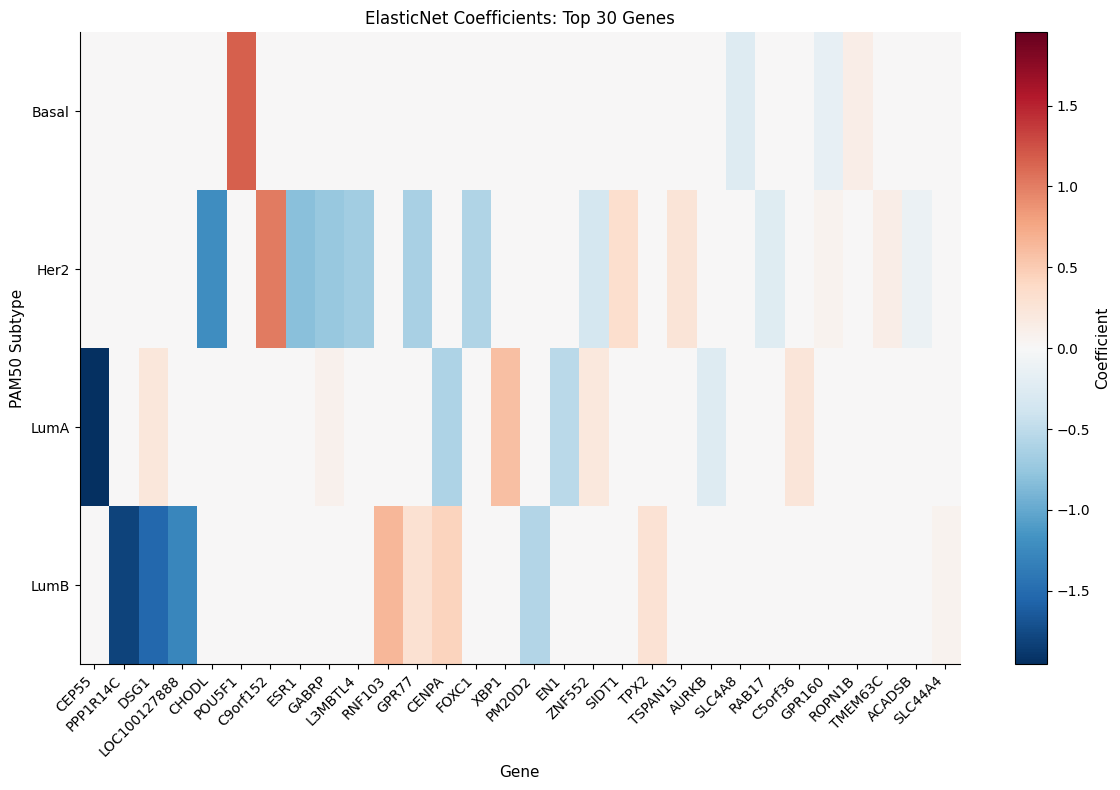

In [40]:
# Top 30 genes by max absolute coefficient
max_abs = np.abs(coef_df).max(axis=0)
top30 = max_abs.nlargest(30).index
plot_df = coef_df[top30]

fig, ax = plt.subplots(figsize=(12, 8))
vmax = np.abs(plot_df.values).max()
im = ax.imshow(plot_df.values, cmap="RdBu_r", aspect="auto", vmin=-vmax, vmax=vmax)
ax.set_xticks(np.arange(len(top30)))
ax.set_yticks(np.arange(len(plot_df.index)))
ax.set_xticklabels(top30, rotation=45, ha="right")
ax.set_yticklabels(plot_df.index)
ax.set_title("ElasticNet Coefficients: Top 30 Genes")
ax.set_xlabel("Gene")
ax.set_ylabel("PAM50 Subtype")
fig.colorbar(im, ax=ax, label="Coefficient")
fig.tight_layout()
fig.savefig(FIGURES_DIR / "04_coefficient_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Feature Selection Stability

In [41]:
print("Analyzing stability across CV folds...")
stability_df = analyze_stability(best_pipeline, X_arr, y_arr, feature_names,
                                  cv_folds=CV_FOLDS, top_k=TOP_K_GENES)

n_stable = (stability_df["top_gene_frequency"] >= STABILITY_THRESHOLD).sum()
print(f"\nStable genes (in top-{TOP_K_GENES} in >{STABILITY_THRESHOLD*100:.0f}% folds): {n_stable}")
print("\nMost stable genes:")
print(stability_df.head(20).to_string(index=False))

Analyzing stability across CV folds...

Stable genes (in top-20 in >50% folds): 99

Most stable genes:
     gene  selection_frequency  top_gene_frequency
    SIDT1                  1.0                 4.0
   TBC1D9                  1.0                 4.0
 C17orf28                  1.0                 3.8
   ZNF552                  1.0                 3.8
     AGR2                  1.0                 3.6
     MLPH                  1.0                 3.6
    FOXC1                  1.0                 3.6
   BCL11A                  1.0                 3.4
    AURKB                  0.8                 3.2
     RND1                  0.8                 3.2
   DLX6AS                  0.8                 3.0
  TSPAN15                  1.0                 3.0
LOC145837                  1.0                 3.0
    PSAT1                  0.8                 3.0
    SPDEF                  1.0                 3.0
    GABRP                  0.8                 2.8
   INPP4B                  1.0

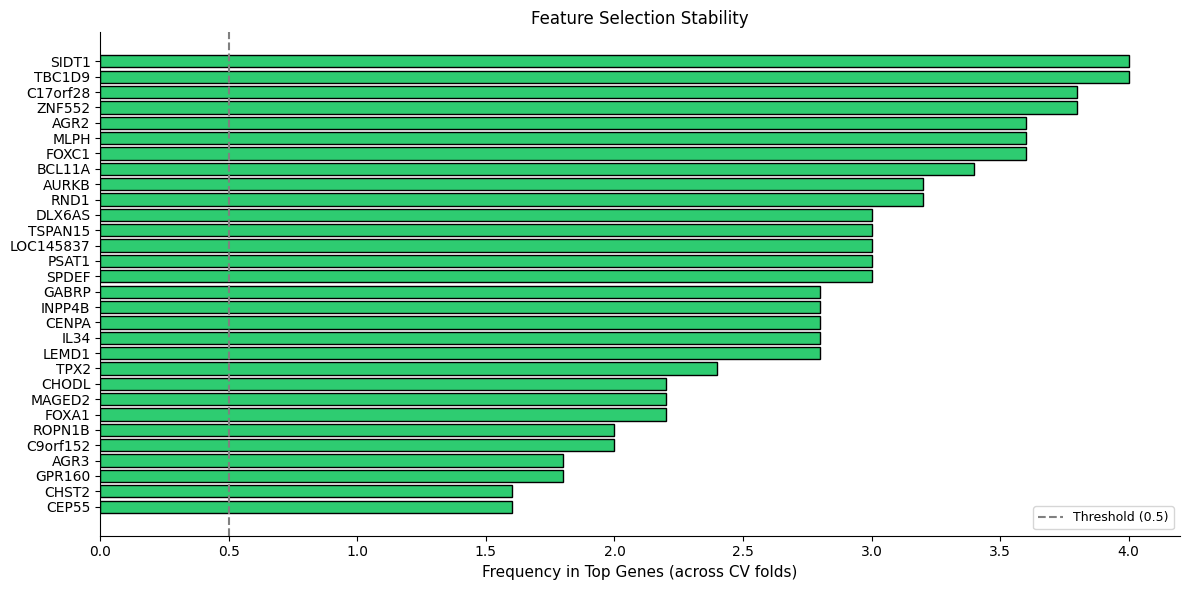

Saved 04_gene_stability.csv


In [42]:
# Plot stability
top_feat = stability_df.head(30)
colors_bar = ["#2ecc71" if f >= STABILITY_THRESHOLD else "#e74c3c"
              for f in top_feat["top_gene_frequency"]]

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(np.arange(len(top_feat)), top_feat["top_gene_frequency"],
        color=colors_bar, edgecolor="black")
ax.set_yticks(np.arange(len(top_feat)))
ax.set_yticklabels(top_feat["gene"])
ax.set_xlabel("Frequency in Top Genes (across CV folds)")
ax.set_title("Feature Selection Stability")
ax.axvline(STABILITY_THRESHOLD, color="gray", linestyle="--", label=f"Threshold ({STABILITY_THRESHOLD})")
ax.legend()
ax.invert_yaxis()
fig.tight_layout()
fig.savefig(FIGURES_DIR / "04_stability_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

stability_df.to_csv(TABLES_DIR / "04_gene_stability.csv", index=False)
print("Saved 04_gene_stability.csv")

## 6. Top Gene Expression Boxplots

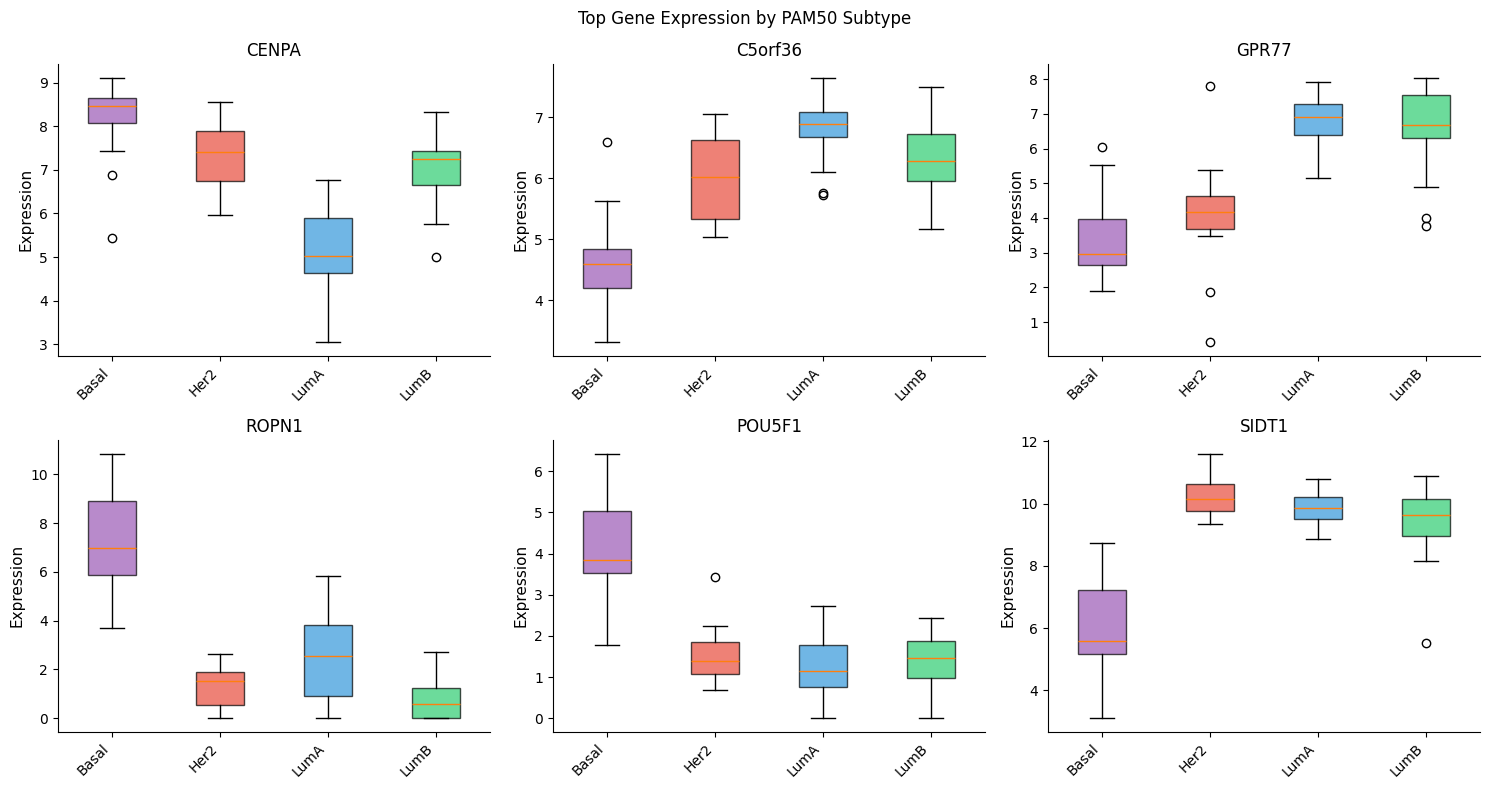

In [43]:
genes_to_plot = set()
for cls, gdf in top_genes.items():
    genes_to_plot.update(gdf[gdf["direction"] == "positive"].head(3)["gene"].tolist())
genes_to_plot = [g for g in genes_to_plot if g in X.columns][:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes_flat = axes.flatten()

for idx, gene in enumerate(genes_to_plot):
    ax = axes_flat[idx]
    data = [X.loc[y == st, gene].values for st in CLASSES_USED]
    bp = ax.boxplot(data, positions=np.arange(len(CLASSES_USED)), patch_artist=True)
    for patch, c in zip(bp["boxes"], [PAM50_COLORS[st] for st in CLASSES_USED]):
        patch.set_facecolor(c)
        patch.set_alpha(0.7)
    ax.set_xticks(np.arange(len(CLASSES_USED)))
    ax.set_xticklabels(CLASSES_USED, rotation=45, ha="right")
    ax.set_title(gene)
    ax.set_ylabel("Expression")

for idx in range(len(genes_to_plot), len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.suptitle("Top Gene Expression by PAM50 Subtype", fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "04_top_gene_expression.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Statistical Validation (Kruskal-Wallis)

In [44]:
test_genes = [g for g in stability_df.head(50)["gene"].tolist() if g in X.columns]
print(f"Testing {len(test_genes)} top genes with Kruskal-Wallis")

kw_results = []
for gene in test_genes:
    groups = [X.loc[y == label, gene].values for label in y.unique()]
    h_stat, p_val = sp_stats.kruskal(*groups)
    kw_results.append({"gene": gene, "h_statistic": h_stat, "p_value": p_val})

kw_df = pd.DataFrame(kw_results)
kw_df["p_adjusted"] = multiple_testing_correction(kw_df["p_value"].tolist())
kw_df["significant"] = kw_df["p_adjusted"] < 0.05
kw_df = kw_df.sort_values("p_value")

n_sig = kw_df["significant"].sum()
print(f"\nSignificant (FDR < 0.05): {n_sig}/{len(test_genes)}")
print("\nTop 20:")
display(kw_df.head(20).round(6))

kw_df.to_csv(TABLES_DIR / "04_kruskal_wallis_results.csv", index=False)
print(f"Saved 04_kruskal_wallis_results.csv")

Testing 50 top genes with Kruskal-Wallis

Significant (FDR < 0.05): 50/50

Top 20:


,gene,h_statistic,p_value,p_adjusted,significant
6,FOXC1,46.660279,0.0,0.0,True
45,PPP1R14C,45.115831,0.0,0.0,True
15,GABRP,45.102068,0.0,0.0,True
1,TBC1D9,43.982008,0.0,0.0,True
39,ESR1,42.724273,0.0,0.0,True
44,DSG1,42.702834,0.0,0.0,True
7,BCL11A,42.079105,0.0,0.0,True
17,CENPA,41.953605,0.0,0.0,True
29,CEP55,41.631336,0.0,0.0,True
38,ROPN1,40.989571,0.0,0.0,True


Saved 04_kruskal_wallis_results.csv


In [45]:
print("\n" + "=" * 60)
print("FEATURE INSIGHTS SUMMARY")
print("=" * 60)
print(f"\nSelected features: {len(selected_features)} genes")
print(f"Stable genes: {n_stable}")
print(f"Statistically significant: {n_sig}/{len(test_genes)}")
print("\nKey outputs:")
print("  - top_genes_all_classes.csv (dashboard)")
print("  - 04_gene_stability.csv")
print("  - 04_kruskal_wallis_results.csv")
print("  - Figures in reports/figures/04_*.png")


FEATURE INSIGHTS SUMMARY

Selected features: 68 genes
Stable genes: 99
Statistically significant: 50/50

Key outputs:
  - top_genes_all_classes.csv (dashboard)
  - 04_gene_stability.csv
  - 04_kruskal_wallis_results.csv
  - Figures in reports/figures/04_*.png
